In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

from varname import nameof
import math

In [2]:
# !pip install gspread
# !pip install --upgrade oauth2client
# !pip install PyOpenSSL

import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [4]:
plt.style.use('seaborn')

<H1> Stock Option Classes </H1>

In [5]:
a = datetime.now()
b = datetime.strptime('2019-01-01', '%Y-%m-%d')
(b-a).days

-923

In [208]:
class Options:
    def __init__(self, ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price=0, max_price=100):
        self.exp_date = datetime.strptime(expiration, '%Y-%m-%d')
        self.exp_date_yr = self.exp_date.year
        self.exp_date_mon = self.exp_date.month
        self.exp_date_day = self.exp_date.day
        
        # format month and date as double digits
        if self.exp_date_mon < 10:
            self.exp_date_mon = '0' + str(self.exp_date_mon)
        if self.exp_date_day < 10:
            self.exp_date_day = '0' + str(self.exp_date_day)
        
        # calculate month from now
        curr_date = datetime.now()
        self.days_from_now = (self.exp_date - curr_date).days
        self.months_from_now = (self.exp_date.year - curr_date.year)*12 + (self.exp_date.month - curr_date.month)
        
        self.ticker = ticker
        self.expiration = expiration
        self.exp_date_trans = str(self.exp_date_yr)[-2:] + str(self.exp_date_mon) + str(self.exp_date_day)
        self.action = action
        self.strike = strike
        self.premium = premium
        self.curr_price = curr_price
        self.imp_vol = imp_vol
        self.min_price = min_price
        self.max_price = max_price
        self.payoff = [] 
        self.weighted_payoff = []
        self.return_ = []
        self.price_prob = {}
        self.pred_price_min = -99
        self.pred_price_max = -99
        self.breakeven =  -99
        self.payoff_min = -99
        self.payoff_max = -99
        self.return_min = -99
        self.return_max = -99
        self.avg_return = -99
             
        if action == 'buy':
            self.cost = round(premium, 1)
        elif action == 'sell':
            self.cost = round(-premium,1)

    def predict_price(self):

        self.std_dev = self.curr_price * self.imp_vol * np.sqrt(self.months_from_now/12)

        num_reps = 1000
        num_iter = 1000
        possible_prices = []

        # Generate all possible prices
        for i in range(num_iter):
            prices = np.random.normal(self.curr_price, self.std_dev, num_reps)
            prices = [int(x) if x>=0 else x for x in prices ]
            possible_prices.extend(prices)

        # count all the prices and create a dictionary
        price_counter = {}
        for price in possible_prices:
            if price_counter.get(price):
                price_counter[price]+=1
            else:
                price_counter[price] = 1 

        # Create a list of probabilities
        total_count = len(possible_prices)
        self.pred_price_min = round(max(min(possible_prices),0),1)
        self.pred_price_max = round(max(possible_prices),1)

        price_prob = [] 

        for price in range(self.min_price, self.max_price+1):
            if price_counter.get(price):
                prob = price_counter[price]/total_count
                price_prob.append(prob)
                self.price_prob[price] = prob
            else:
                price_prob.append(0)
                self.price_prob[price] = 0
        
    def calc_payoff(self):
        for price in range (self.min_price, self.max_price+1):
            earn = self.calc_profit(price)
            weighted_earn = earn * self.price_prob[price]
            self.payoff.append(earn)
            self.weighted_payoff.append(weighted_earn)
        
        try: self.breakeven = list(self.payoff).index(0)
        except: 
            minimum = min(self.payoff, key = abs)
            self.breakeven = list(self.payoff).index(minimum)
            
        self.breakeven  = round(self.breakeven,1)
        self.payoff_min = round(min(self.payoff),1)
        self.payoff_max = round(max(self.payoff),1)
        self.avg_payoff = round(sum(self.weighted_payoff),3)
        
    def calc_return(self):
        for payoff in self.payoff:
            return_ = round(payoff/self.cost,3)
            self.return_.append(return_)
        self.return_min = round(self.payoff_min/self.cost,3)
        self.return_max = round(self.payoff_max/self.cost,3)
        self.avg_return = round(self.avg_payoff/self.cost,3)
        self.avg_annualized_return = round(pow(1 + self.avg_return, 365/self.days_from_now)-1, 3)
    
    def create_graph(self):

        max_x = self.max_price
        min_x = self.min_price
        interval = (max_x - min_x)/10
        
        max_y = self.payoff_max + interval
        min_y = self.payoff_min - 5*interval
        
        x = np.arange(min_x, max_x +1, 1)
        y = self.payoff
        
        print('Strategy:', self.name, 
#               '\nPrice Range:[', self.pred_price_min, ',', self.pred_price_max,
              '\nPayoff Range:[', self.payoff_min, ',', self.payoff_max, 
              '];Breakeven Price:', self.breakeven,
              ';Cost:', self.cost,
               ';Return Range:[', "{:.1%}".format(self.return_min), ',', "{:.1%}".format(self.return_max), ']',
              '; Avg. Return:',"{:.1%}".format(self.avg_return),
              '; Avg. Annual Return:',"{:.1%}".format(self.avg_annualized_return),
              '\n'
             )
        
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.xticks(np.arange(min_x, max_x+interval, interval))
        plt.yticks(np.arange(min_y, max_y, interval))
        
        plt.xlim (min_x, max_x) # limit range of x to show
        plt.ylim (min_y, max_y)
    #     plt.legend(loc = 'upper left')
        plt.plot(x, y, label = self.name )
        plt.legend()
        
    def create_graph_stock_only(self):
        max_x = self.max_price
        min_x = self.min_price
        interval = (max_x - min_x)/10
        
        max_y = self.payoff_max + interval
        min_y = self.payoff_min - 5*interval
        
        current_price = round(self.curr_price,1)
        
        x = np.arange(min_x, max_x+1, 1)
        y = [a - current_price for a in x]
        
        payoff_min = round(min(x) - current_price,1)
        payoff_max = round(max(x) - current_price, 1)
        cost = round(current_price,1)
        return_min = round(payoff_min/cost,3)
        return_max = round(payoff_max/cost,3)
        

        print('Strategy: Stock Only', 
              '\nPrice Range:[', self.pred_price_min, ',', self.pred_price_max,
              '];Payoff Range:[', payoff_min, ',', payoff_max, 
              '];Breakeven Price:', current_price,
              'Cost:', cost,
              ';Return Range:[', "{:.1%}".format(return_min), ',', "{:.1%}".format(return_max), ']'
#               '; Average Return:',"{:.1%}".format(self.avg_return)
             )
        plt.xticks(np.arange(0, max_x+interval, interval))
        plt.yticks(np.arange(min_y , max_y, interval))
    #     plt.legend(loc = 'upper left')
        plt.xlim (min_x, max_x)
        plt.ylim (min_y, max_y)
        plt.plot(x, y, label = 'Stock Only' )
        plt.legend()

In [209]:
class Call(Options):
    def __init__(self, ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price=0, max_price=100):
        super().__init__(ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price, max_price)
        self.name = self.ticker + self.exp_date_trans + 'C'+ str(self.strike)
        self.type = 'call'
        self.predict_price()
        self.calc_payoff()
        self.calc_return()
        
        
    def calc_profit(self, price):
        if self.action == 'buy':
            if price <= self.strike:
                profit =  -self.premium
            elif price > self.strike:
                profit = price - self.strike - self.premium
            
        elif self.action == 'sell':
            if price <= self.strike:
                profit = self.premium
            elif price > self.strike:
                profit = - price + self.strike + self.premium
                
        return profit
      

In [210]:
class Put(Options):
    def __init__(self, ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price=0, max_price=100):
        super().__init__(ticker, expiration, action, strike, premium, curr_price, imp_vol, min_price, max_price)
        self.name = self.ticker + self.exp_date_trans + 'P'+ str(self.strike)
        self.type = 'put'
        self.predict_price()
        self.calc_payoff()
        self.calc_return()
        
    def calc_profit(self, price):
        if self.action == 'buy':
            if price <= self.strike:
                profit = self.strike - price - self.premium
            elif price > self.strike:
                profit = - self.premium
            
        elif self.action == 'sell':
            if price <= self.strike:
                profit = - self.strike + price + self.premium
            elif price > self.strike:
                profit = self.premium
        return profit
            

In [214]:
class OptionsStrategy:
    def __init__(self, options_list, coefficients = []):
        self.ticker = options_list[0].ticker
        self.exp_date_trans = options_list[0].exp_date_trans
        self.min_price = options_list[0].min_price
        self.max_price = options_list[0].max_price
        self.pred_price_min = options_list[0].pred_price_min
        self.pred_price_max = options_list[0].pred_price_max
        self.days_from_now = options_list[0].days_from_now
        self.months_from_now = options_list[0].months_from_now
        self.curr_price = options_list[0].curr_price
        self.options_list = options_list
        self.coefficients = coefficients
        
        self.payoff = []
        self.weighted_payoff = []
        self.return_ = []
        self.breakeven = -99
        self.payoff_min = -99
        self.payoff_max = -99
        self.return_min = -99
        self.return_max = -99
        self.avg_return = -99
        self.avg_payoff = -99

        self.create_name()
        self.calc_payoff()
        self.calc_return()
    
    def create_name(self):
        self.name = self.ticker + self.exp_date_trans
        for option in self.options_list:
            # Add action, option type, strike price to combo name
            if option.action == 'buy':
                self.name+='_B'
            elif option.action == 'sell':
                self.name+='_S'
                
            if option.type == 'call':
                self.name+='C'
            elif option.type == 'put':
                self.name+='P'
            
            self.name+=str(option.strike)
            
    def calc_payoff(self):
        self.cost = 0
        data_shape = len(self.options_list[0].payoff)
        if len(self.coefficients) == 0:
            self.coefficients = np.ones(data_shape)
            
        for index, option in enumerate(self.options_list):
            self.cost+=self.coefficients[index] * option.cost
            if len(self.payoff)==0:
                self.payoff = self.coefficients[index] * np.array(option.payoff) 
                self.weighted_payoff = self.coefficients[index] * np.array(option.weighted_payoff) 
            else:
                self.payoff = np.add(self.payoff, 
                                     self.coefficients[index] * np.array(option.payoff)
                                    )
                self.weighted_payoff = np.add(self.weighted_payoff, 
                                     self.coefficients[index] * np.array(option.weighted_payoff)
                                    )
        self.cost = round(self.cost, 1)
            
        
        # calculate breakeven, payoff_min, payoff_max
        try: self.breakeven = list(self.payoff).index(0)
        except: 
            minimum = min(self.payoff, key = abs)
            self.breakeven = list(self.payoff).index(minimum)
            
        self.breakeven  = round(self.breakeven,1)
        self.payoff_min = round(min(self.payoff),1)
        self.payoff_max = round(max(self.payoff),1)
        self.avg_payoff = round(sum(self.weighted_payoff),3)
        
    
    def calc_return(self):
        for payoff in self.payoff:
            return_ = round(payoff/self.cost,3)
            self.return_.append(return_)
        self.return_min = round(self.payoff_min/self.cost,3)
        self.return_max = round(self.payoff_max/self.cost,3)
        self.avg_return = round(self.avg_payoff/self.cost,3)
        self.avg_annualized_return = round(pow(1 + self.avg_return, 365/self.days_from_now)-1, 3)
        
    
    def create_graph(self):

        max_x = self.max_price
        min_x = self.min_price
        interval = (max_x - min_x)/10
        
        max_y = self.payoff_max + interval
        min_y = self.payoff_min - 5*interval
        
        x = np.arange(min_x, max_x +1, 1)
        y = self.payoff
        
        print('Strategy:', self.name, 
#               '\nPrice Range:[', self.pred_price_min, ',', self.pred_price_max,
              '\nPayoff Range:[', self.payoff_min, ',', self.payoff_max, 
              '];Breakeven Price:', self.breakeven,
              ';Cost:', self.cost,
               ';Return Range:[', "{:.1%}".format(self.return_min), ',', "{:.1%}".format(self.return_max), ']',
              '; Avg. Return:',"{:.1%}".format(self.avg_return),
              '; Avg. Annual Return:',"{:.1%}".format(self.avg_annualized_return),
              '\n'
             )
        
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.xticks(np.arange(min_x, max_x+interval, interval))
        plt.yticks(np.arange(min_y, max_y, interval))
        
        plt.xlim (min_x, max_x) # limit range of x to show
        plt.ylim (min_y, max_y)
    #     plt.legend(loc = 'upper left')
        plt.plot(x, y, label = self.name )
        plt.legend()
        
    def create_graph_stock_only(self):
        max_x = self.max_price
        min_x = self.min_price
        interval = (max_x - min_x)/10
        
        max_y = self.payoff_max + interval
        min_y = self.payoff_min - 5*interval
        
        current_price = round(self.curr_price,1)
        
        x = np.arange(min_x, max_x+1, 1)
        y = [a - current_price for a in x]
        
        payoff_min = round(min(x) - current_price,1)
        payoff_max = round(max(x) - current_price, 1)
        cost = round(current_price,1)
        return_min = round(payoff_min/cost,3)
        return_max = round(payoff_max/cost,3)
        

        print('Strategy: Stock Only', 
              '\nPrice Range:[', self.pred_price_min, ',', self.pred_price_max,
              '];Payoff Range:[', payoff_min, ',', payoff_max, 
              '];Breakeven Price:', current_price,
              'Cost:', cost,
              ';Return Range:[', "{:.1%}".format(return_min), ',', "{:.1%}".format(return_max), ']'
#               '; Average Return:',"{:.1%}".format(self.avg_return)
             )
        plt.xticks(np.arange(0, max_x+interval, interval))
        plt.yticks(np.arange(min_y , max_y, interval))
    #     plt.legend(loc = 'upper left')
        plt.xlim (min_x, max_x)
        plt.ylim (min_y, max_y)
        plt.plot(x, y, label = 'Stock Only' )
        plt.legend()
             

<h1>Applications</H1>

In [14]:
import importlib
importlib.reload(options)

<module 'options' from '/Users/xzhou/github/stock/stock_options_trading/options.py'>

In [15]:
bc20 = options.Call('NIO', '2025-01-02', 'buy', 20, 48, 58, 0.33)
bc20.create_graph()

NameError: name 'np' is not defined

Strategy: NIO250105C20 
Payoff Range:[ -48 , 32 ];Breakeven Price: 68 ;Cost: 48 ;Return Range:[ -100.0% , 66.7% ] ; Avg. Return: -22.6% ; Avg. Annual Return: -6.3% 

Strategy: NIO250115C50 
Payoff Range:[ -35 , 15 ];Breakeven Price: 65 ;Cost: -15 ;Return Range:[ 233.3% , -100.0% ] ; Avg. Return: -12.6% ; Avg. Annual Return: -3.3% 

Strategy: NIO250105P30 
Payoff Range:[ -35 , -5 ];Breakeven Price: 0 ;Cost: 35 ;Return Range:[ -100.0% , -14.3% ] ; Avg. Return: -74.1% ; Avg. Annual Return: -29.1% 

Strategy: NIO250105P60 
Payoff Range:[ -52 , 8 ];Breakeven Price: 52 ;Cost: -8 ;Return Range:[ 650.0% , -100.0% ] ; Avg. Return: 64.1% ; Avg. Annual Return: 13.4% 

Strategy: Stock Only 
Price Range:[ 0 , 240 ];Payoff Range:[ -58 , 42 ];Breakeven Price: 58 Cost: 58 ;Return Range:[ -100.0% , 72.4% ]


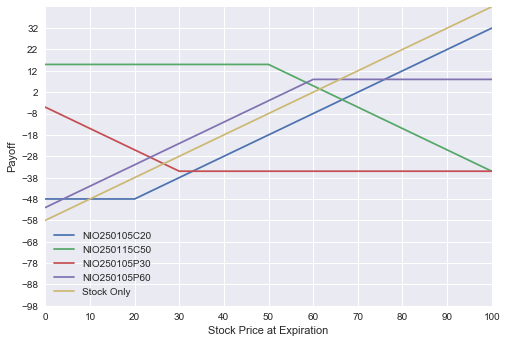

In [216]:
bc20 = Call('NIO', '2025-01-05', 'buy', 20, 48, 58, 0.33)
sc50 = Call('NIO', '2025-01-15', 'sell', 50, 15, 58, 0.33)
bp30 = Put('NIO', '2025-01-05', 'buy', 30, 35, 58, 0.33)
sp60 = Put('NIO', '2025-01-05', 'sell', 60, 8, 58, 0.33)

# create_graph(bc20.name, bc20.payoff, bc20.cost)
# create_graph(sc50.name, sc50.payoff, sc50.cost)
# create_graph(bp30.name, bp30.payoff, bp30.cost)
# create_graph(sp60.name, sp60.payoff, sp60.cost)

bc20.create_graph()
sc50.create_graph()
bp30.create_graph()
sp60.create_graph()

bc20.create_graph_stock_only()


Strategy: NIO250105_BC20_SC50 
Price Range:[ 0 , 248 ];Payoff Range:[ -33.0 , -3.0 ];Breakeven Price: 50 ;Cost: 33.0 ;Return Range:[ -100.0% , -9.1% ] ; Avg. Return: -27.2% ; Avg. Annual Return: -7.8% 

Strategy: NIO250115_SC50_SP60 
Price Range:[ 0 , 251 ];Payoff Range:[ -37.0 , 13.0 ];Breakeven Price: 37 ;Cost: -23.0 ;Return Range:[ 160.9% , -56.5% ] ; Avg. Return: 14.1% ; Avg. Annual Return: 3.4% 

Strategy: Stock Only
 Payoff Range:[ -58 , 42 ];Breakeven Price: 58 Cost: 58 ;Return Range:[ -100.0% , 72.4% ]


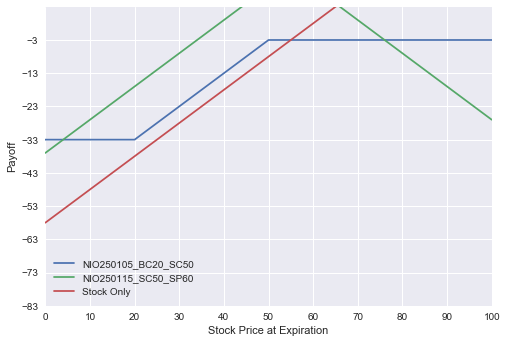

In [179]:
# optioin_strategy: approach #2 - OptionStrategy


bc20_sc50 = OptionsStrategy([bc20, sc50])
sc50_sp60 = OptionsStrategy([sc50, sp60])

bc20_sc50.create_graph()
sc50_sp60.create_graph()
bc20_sc50.create_graph_stock_only()

Strategy: NIO210501_BC50_SC80 
Price Range:[ 1 , 111 ];Payoff Range:[ -5.0 , 25.0 ];Breakeven Price: 55 ;Cost: 5.0 ;Return Range:[ -100.0% , 500.0% ] ; Avg. Return: 80.9% ; Avg. Annual Return: 1037.1% 

Strategy: Stock Only
 Payoff Range:[ -58 , 42 ];Breakeven Price: 58 Cost: 58 ;Return Range:[ -100.0% , 72.4% ]


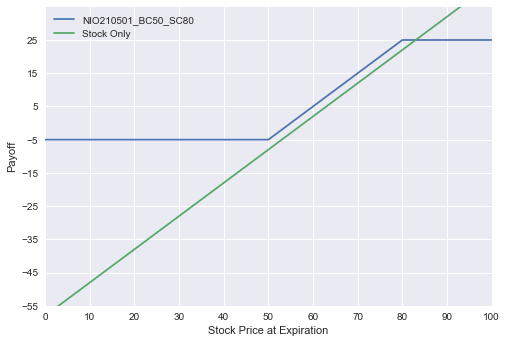

In [180]:
# Bull Spread Strategy: buy call 50 and sell call 80

bc50 = Call('NIO', '2021-05-01', 'buy', 50, 20, 58, 0.33)
sc80 = Call('NIO', '2021-05-01', 'sell', 80, 15, 58, 0.33)

bc50_sc80 = OptionsStrategy([bc50, sc80])

bc50_sc80.create_graph()
bc50_sc80.create_graph_stock_only()

Strategy: NIO210501_BC50_BP50 
Price Range:[ 6 , 112 ];Payoff Range:[ -35.0 , 15.0 ];Breakeven Price: 15 ;Cost: 35.0 ;Return Range:[ -100.0% , 42.9% ] ; Avg. Return: -69.2% ; Avg. Annual Return: -99.2% 

Strategy: Stock Only
 Payoff Range:[ -58 , 42 ];Breakeven Price: 58 Cost: 58 ;Return Range:[ -100.0% , 72.4% ]


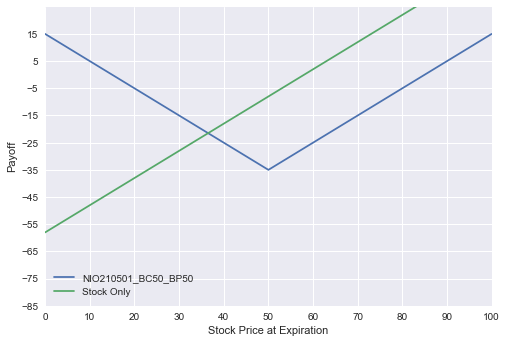

In [182]:
# Straddle Strategy: buy call 50 and buy put 50

bc50 = Call('NIO', '2021-05-01', 'buy', 50, 20, 58, 0.33)
bp50 = Put('NIO', '2021-05-01', 'buy', 50, 15, 58, 0.33)

bc50_sc80 = OptionsStrategy([bc50, bp50])

bc50_sc80.create_graph()
bc50_sc80.create_graph_stock_only()

Strategy: NIO210501_BC50_SC60_BC70 
Price Range:[ 7 , 121 ];Payoff Range:[ -4 , 6 ];Breakeven Price: 54 ;Cost: 4 ;Return Range:[ -100.0% , 150.0% ] ; Avg. Return: -17.6% ; Avg. Annual Return: -54.8% 

Strategy: Stock Only
 Payoff Range:[ -58 , 42 ];Breakeven Price: 58 Cost: 58 ;Return Range:[ -100.0% , 72.4% ]


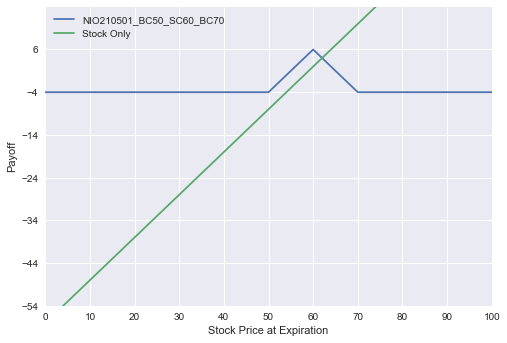

In [184]:
# Butterfly Spread Strategy: buy 1 call 50, sell 2 call 60, and buy a call 70

bc50 = Call('NIO', '2021-05-01', 'buy', 50, 12, 58, 0.33)
sc60 = Call('NIO', '2021-05-01', 'sell', 60, 5, 58, 0.33)
bc70 = Call('NIO', '2021-05-01', 'buy', 70, 2, 58, 0.33)

bc50_sc60_bc70 = OptionsStrategy([bc50, sc60, bc70], coefficients = [1, 2, 1])

bc50_sc60_bc70.create_graph()
bc50_sc60_bc70.create_graph_stock_only()

Strategy: NIO230120_BC3_BP5 
Price Range:[ 0 , 189 ];Payoff Range:[ -57.0 , 138.0 ];Breakeven Price: 62 ;Cost: 59.0 ;Return Range:[ -96.6% , 233.9% ] ; Avg. Return: -5.5% ; Avg. Annual Return: -2.8% 

Strategy: Stock Only
 Payoff Range:[ -58 , 142 ];Breakeven Price: 58 Cost: 58 ;Return Range:[ -100.0% , 244.8% ]


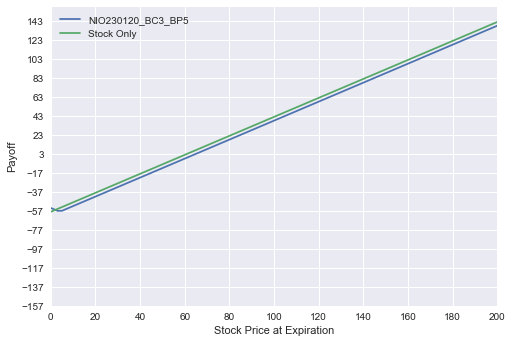

In [186]:
# Stragegy: buy call @3 and buy put @5

nio_bc3 = Call('NIO', '2023-01-20', 'buy', 3, 58.38, 58, 0.33, max_price=200)
nio_bp5 = Put('NIO', '2023-01-20', 'buy', 5, 0.59, 58, 0.33, max_price=200)

nio_bc3_bp5 = OptionsStrategy([nio_bc3, nio_bp5])

nio_bc3_bp5.create_graph()
nio_bc3_bp5.create_graph_stock_only()

/Users/xzhou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in double_scalars


Strategy: NIO230120_BC3_BP5 
Payoff Range:[ -57.0 , 138.0 ];Breakeven Price: 62 ;Cost: 59.0 ;Return Range:[ -96.6% , 233.9% ] ; Avg. Return: -5.6% ; Avg. Annual Return: -2.9% 

Strategy: NIO230120_BC3_SP45 
Payoff Range:[ -84.9 , 157.1 ];Breakeven Price: 44 ;Cost: 40.0 ;Return Range:[ -212.2% , 392.7% ] ; Avg. Return: 26.6% ; Avg. Annual Return: 12.7% 

Strategy: NIO230120_BC3_SP60 
Payoff Range:[ -88.9 , 168.1 ];Breakeven Price: 46 ;Cost: 28.9 ;Return Range:[ -307.6% , 581.7% ] ; Avg. Return: 53.1% ; Avg. Annual Return: 24.2% 

Strategy: NIO230120_BC3_SP70 
Payoff Range:[ -91.1 , 175.9 ];Breakeven Price: 47 ;Cost: 21.1 ;Return Range:[ -431.8% , 833.6% ] ; Avg. Return: 81.0% ; Avg. Annual Return: 35.2% 

Strategy: NIO230120_BC3_SP80 
Payoff Range:[ -93.9 , 183.1 ];Breakeven Price: 48 ;Cost: 13.9 ;Return Range:[ -675.5% , 1317.3% ] ; Avg. Return: 121.7% ; Avg. Annual Return: 49.9% 

Strategy: NIO230120_BC3_SP85 
Payoff Range:[ -98.4 , 183.6 ];Breakeven Price: 51 ;Cost: 13.4 ;Return Rang

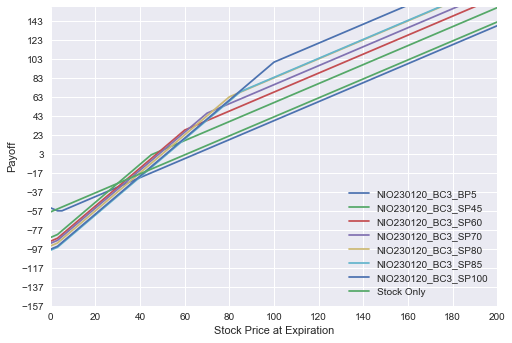

In [217]:
# NIO strategies

nio_bc3 = Call('NIO', '2023-01-20', 'buy', 3, 58.38, 58, 0.33, max_price=200)
nio_bp5 = Put('NIO', '2023-01-20', 'buy', 5, 0.59, 58, 0.33, max_price=200)
nio_sp45 = Put('NIO', '2023-01-20', 'sell', 45, 18.45, 58, 0.33, max_price=200)
nio_sp60 = Put('NIO', '2023-01-20', 'sell', 60, 29.5, 58, 0.33, max_price=200)
nio_sp70 = Put('NIO', '2023-01-20', 'sell', 70, 37.3, 58, 0.33, max_price=200)
nio_sp80 = Put('NIO', '2023-01-20', 'sell', 80, 44.5, 58, 0.33, max_price=200)
nio_sp85 = Put('NIO', '2023-01-20', 'sell', 85, 45, 58, 0.33, max_price=200)
nio_sp100 = Put('NIO', '2023-01-20', 'sell', 100, 61.05, 58, 0.33, max_price=200)


s1 = OptionsStrategy([nio_bc3, nio_bp5])
s2 = OptionsStrategy([nio_bc3, nio_sp45])
s3 = OptionsStrategy([nio_bc3, nio_sp60])
s4 = OptionsStrategy([nio_bc3, nio_sp70])
s5 = OptionsStrategy([nio_bc3, nio_sp80])
s6 = OptionsStrategy([nio_bc3, nio_sp85])
s7 = OptionsStrategy([nio_bc3, nio_sp100])


for strategy in [s1, s2, s3, s4, s5, s6, s7]:
    strategy.create_graph()

s1.create_graph_stock_only()

Strategy: RIOT230120C7 
Payoff Range:[ -22.1 , 70.9 ];Breakeven Price: 29 ;Cost: 22.1 ;Return Range:[ -100.0% , 320.8% ] ; Avg. Return: 30.7% ; Avg. Annual Return: 14.6% 

Strategy: RIOT230120C10 
Payoff Range:[ -20.2 , 69.8 ];Breakeven Price: 30 ;Cost: 20.2 ;Return Range:[ -100.0% , 345.5% ] ; Avg. Return: 30.5% ; Avg. Annual Return: 14.5% 

Strategy: RIOT230120C12 
Payoff Range:[ -20.6 , 67.5 ];Breakeven Price: 33 ;Cost: 20.6 ;Return Range:[ -100.0% , 327.7% ] ; Avg. Return: 22.6% ; Avg. Annual Return: 10.9% 

Strategy: RIOT230120C15 
Payoff Range:[ -20 , 65 ];Breakeven Price: 35 ;Cost: 20 ;Return Range:[ -100.0% , 325.0% ] ; Avg. Return: 16.2% ; Avg. Annual Return: 7.9% 

Strategy: RIOT230120C17 
Payoff Range:[ -18.6 , 64.5 ];Breakeven Price: 36 ;Cost: 18.6 ;Return Range:[ -100.0% , 346.8% ] ; Avg. Return: 16.9% ; Avg. Annual Return: 8.3% 

Strategy: RIOT230120C20 
Payoff Range:[ -18.9 , 61.1 ];Breakeven Price: 39 ;Cost: 18.9 ;Return Range:[ -100.0% , 323.3% ] ; Avg. Return: 6.6% ; 

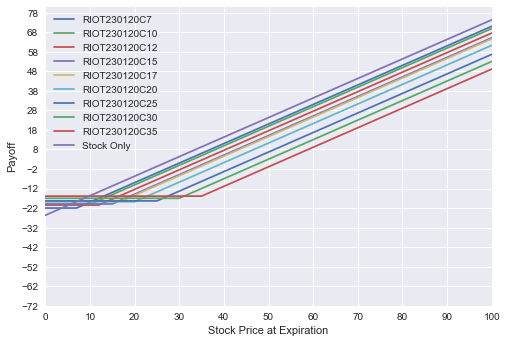

In [221]:
# Riot Strategy

s1 = Call('RIOT', '2023-01-20', 'buy', 7, 22.10, 25.84, 0.97,    max_price=100)
s2 = Call('RIOT', '2023-01-20', 'buy', 10, 20.25, 25.84, 0.97,   max_price=100)
s3 = Call('RIOT', '2023-01-20', 'buy', 12, 20.55, 25.84, 0.97,   max_price=100)
s4 = Call('RIOT', '2023-01-20', 'buy', 15, 20, 25.84, 0.97,      max_price=100)
s5 = Call('RIOT', '2023-01-20', 'buy', 17, 18.55, 25.84, 0.97,   max_price=100)
s6 = Call('RIOT', '2023-01-20', 'buy', 20, 18.85, 25.84, 0.97,   max_price=100)
s7 = Call('RIOT', '2023-01-20', 'buy', 25, 18.45, 25.84, 0.97,   max_price=100)
s8 = Call('RIOT', '2023-01-20', 'buy', 30, 17.10, 25.84, 0.97,   max_price=100)
s9 = Call('RIOT', '2023-01-20', 'buy', 35, 16, 25.84, 0.97,      max_price=100)


for strategy in [s1, s2, s3, s4, s5, s6, s7, s8, s9]:
    strategy.create_graph()

s1.create_graph_stock_only()

Strategy: ARKK230120C47.96 
Payoff Range:[ -100.8 , 151.2 ];Breakeven Price: 149 ;Cost: 100.8 ;Return Range:[ -100.0% , 150.0% ] ; Avg. Return: -1.7% ; Avg. Annual Return: -0.9% 

Strategy: ARKK230120C67.96 
Payoff Range:[ -85.3 , 146.7 ];Breakeven Price: 153 ;Cost: 85.3 ;Return Range:[ -100.0% , 172.0% ] ; Avg. Return: -4.4% ; Avg. Annual Return: -2.3% 

Strategy: ARKK230120C77.96 
Payoff Range:[ -77.9 , 144.1 ];Breakeven Price: 156 ;Cost: 77.9 ;Return Range:[ -100.0% , 185.0% ] ; Avg. Return: -6.3% ; Avg. Annual Return: -3.3% 

Strategy: ARKK230120C87.96 
Payoff Range:[ -71.1 , 140.9 ];Breakeven Price: 159 ;Cost: 71.1 ;Return Range:[ -100.0% , 198.2% ] ; Avg. Return: -8.1% ; Avg. Annual Return: -4.2% 

Strategy: ARKK230120C107.96 
Payoff Range:[ -60.1 , 131.9 ];Breakeven Price: 168 ;Cost: 60.1 ;Return Range:[ -100.0% , 219.5% ] ; Avg. Return: -15.6% ; Avg. Annual Return: -8.3% 

Strategy: ARKK230120C117.96 
Payoff Range:[ -56.4 , 125.6 ];Breakeven Price: 174 ;Cost: 56.4 ;Return Range

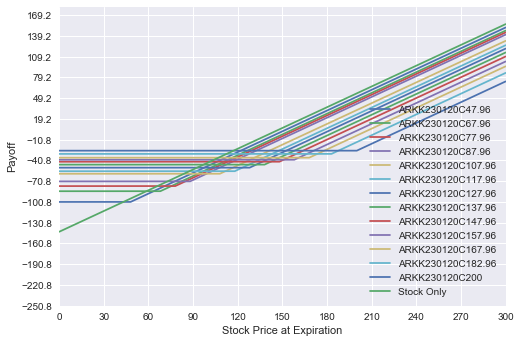

In [219]:
# ARK Calls

s1  = Call('ARKK', '2023-01-20', 'buy', 47.96, 100.80, 143.94, 0.39,   max_price=300)
s2  = Call('ARKK', '2023-01-20', 'buy', 67.96, 85.30, 143.94, 0.39,    max_price=300)
s3  = Call('ARKK', '2023-01-20', 'buy', 77.96, 77.90, 143.94, 0.39,    max_price=300)
s4  = Call('ARKK', '2023-01-20', 'buy', 87.96, 71.10, 143.94, 0.39,    max_price=300)
s5  = Call('ARKK', '2023-01-20', 'buy', 107.96, 60.10, 143.94, 0.39,   max_price=300)
s6  = Call('ARKK', '2023-01-20', 'buy', 117.96, 56.40, 143.94, 0.39,   max_price=300)
s7  = Call('ARKK', '2023-01-20', 'buy', 127.96, 51.30, 143.94, 0.39,   max_price=300)
s8  = Call('ARKK', '2023-01-20', 'buy', 137.96, 46.90, 143.94, 0.39,   max_price=300)
s9  = Call('ARKK', '2023-01-20', 'buy', 147.96, 42.70, 143.94, 0.39,   max_price=300)
s10 = Call('ARKK', '2023-01-20', 'buy', 157.96, 39.90, 143.94, 0.39,   max_price=300)
s11 = Call('ARKK', '2023-01-20', 'buy', 167.96, 36.90, 143.94, 0.39,   max_price=300)
s12 = Call('ARKK', '2023-01-20', 'buy', 182.96, 31.40, 143.94, 0.39,   max_price=300)
s13 = Call('ARKK', '2023-01-20', 'buy', 200, 26.70, 143.94, 0.39,      max_price=300)

for strategy in [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13]:
    strategy.create_graph()

s1.create_graph_stock_only()

Strategy: TSLA210129_BC830_BP800 
Payoff Range:[ -75.7 , 94.3 ];Breakeven Price: 24 ;Cost: 75.7 ;Return Range:[ -100.0% , 124.6% ] ; Avg. Return: -24.3% ; Avg. Annual Return: 51286295163731904.0% 

Strategy: TSLA230129_BC850_BP850 
Payoff Range:[ -81.2 , 68.8 ];Breakeven Price: 69 ;Cost: 81.1 ;Return Range:[ -100.1% , 84.8% ] ; Avg. Return: -1.6% ; Avg. Annual Return: -0.8% 

Strategy: TSLA230129_BC870_BP870 
Payoff Range:[ -81.8 , 88.2 ];Breakeven Price: 88 ;Cost: 81.8 ;Return Range:[ -100.0% , 107.8% ] ; Avg. Return: -1.4% ; Avg. Annual Return: -0.7% 

Strategy: TSLA230129_BC875_BP875 
Payoff Range:[ -82.2 , 92.8 ];Breakeven Price: 93 ;Cost: 82.2 ;Return Range:[ -100.0% , 112.9% ] ; Avg. Return: -1.4% ; Avg. Annual Return: -0.7% 

Strategy: Stock Only 
Price Range:[ 876 , 876 ];Payoff Range:[ -176.4 , 123.6 ];Breakeven Price: 876.4 Cost: 876.4 ;Return Range:[ -20.1% , 14.1% ]


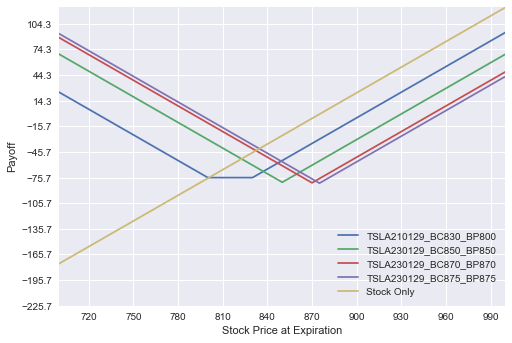

In [222]:
c1 = Call('TSLA', '2021-01-29', 'buy', 830, 65.75, 876.38, 0.45, min_price=700,  max_price=1000)
c2 = Call('TSLA', '2023-01-29', 'buy', 850, 54, 876.38, 0.45,    min_price=700,    max_price=1000)
c3 = Call('TSLA', '2023-01-29', 'buy', 870, 44.2, 876.38, 0.45,  min_price=700,  max_price=1000)
c4 = Call('TSLA', '2023-01-29', 'buy', 875, 41.8, 876.38, 0.45,  min_price=700,  max_price=1000)

p1 = Put('TSLA', '2023-01-29', 'buy', 800, 9.95, 876.38, 0.45,   min_price=700, max_price=1000)
p2 = Put('TSLA', '2023-01-29', 'buy', 850, 27.15, 876.38, 0.45,  min_price=700, max_price=1000)
p3 = Put('TSLA', '2023-01-29', 'buy', 870, 37.60, 876.38, 0.45,  min_price=700, max_price=1000)
p4 = Put('TSLA', '2023-01-29', 'buy', 875, 40.40, 876.38, 0.45,  min_price=700, max_price=1000)


s1 = OptionsStrategy([c1, p1])
s2 = OptionsStrategy([c2, p2])
s3 = OptionsStrategy([c3, p3])
s4 = OptionsStrategy([c4, p4])
s5 = OptionsStrategy([c4, p1])


for strategy in [s1, s2, s3, s4]:
    strategy.create_graph()
s1.create_graph_stock_only()

<h1> Google Sheet Helper </h1>

In [ ]:
def read_google_sheet(google_sheet_name, tab_name):

    scope = ['https://spreadsheets.google.com/feeds',
             'https://www.googleapis.com/auth/drive']

    credentials = ServiceAccountCredentials.from_json_keyfile_name(
             '../../backup/google_api/stock-options-assessment-236c62880c44.json', scope) # Your json file here

    client = gspread.authorize(credentials)
    spreadsheetName = google_sheet_name
    sheetName = tab_name
    
    spreadsheet = client.open(spreadsheetName)
    sheet = spreadsheet.worksheet(sheetName)
    
    data = sheet.get_all_values()
    headers = data.pop(0)

    df = pd.DataFrame(data, columns=headers)
    display(df.head())
    
    return df

In [ ]:
df = read_google_sheet("stock_options_data", "nio_210118")

In [ ]:
std = 61.95*0.9531*np.sqrt(5/12)

<H1> Monte Carlo Price Prediction </H1>

In [ ]:
def predict_price(curr_price, imp_vol, exp_date):

    exp_date = datetime.strptime(exp_date, '%Y-%m-%d')
    curr_date = datetime.now()
    month_from_now = (exp_date.year - curr_date.year)*12 + (exp_date.month - curr_date.month) 



    std_dev = curr_price * imp_vol * np.sqrt(month_from_now/12)

    num_reps = 1000
    num_iter = 1000
    possible_prices = []

    # Generate all possible prices
    for i in range(num_iter):
        prices = np.random.normal(curr_price, std_dev, num_reps)
        prices = [int(x) if x>=0 else x for x in prices ]
        possible_prices.extend(prices)

    # count all the prices and create a dictionary
    price_counter = {}
    for price in possible_prices:
        if price_counter.get(price):
            price_counter[price]+=1
        else:
            price_counter[price] = 1 

    # Create a list of counts and a list of probabilities
    max_price = 200
    total_count = len(possible_prices)

    price_count = []
    price_prob = [] 


    for price in range(max_price):
        if price_counter.get(price):
            price_count.append(price_counter[price])

            prob = price_counter[price]/total_count
            price_prob.append(prob)
        else:
            price_count.append(0)
            price_prob.append(0)


    plt.bar(range(max_price), price_count)

In [ ]:
curr_price = 61.95
imp_vol = 0.9531
exp_date = '2021-05-18'

predict_price(curr_price, imp_vol, exp_date)